In [1]:
#%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
conn = engine.connect()
data = pd.read_sql("SELECT * FROM measurement", conn)
data.head()

#station = pd.read_sql("SELECT * FROM station", conn)
#station.head()

#Latest Date
#x = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
#session.query(func.count(Measurement.date)).all
#session.query(Measurement.date).\
#    order_by(Measurement.date).all()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


# Exploratory Climate Analysis

2018-09-08
2017-09-08
('2017-08-23',)
2016-08-23


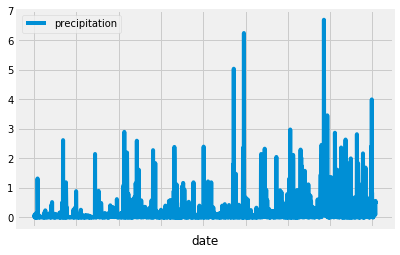

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
print(dt.date.today())
yearAgo = dt.date.today()-dt.timedelta(days=365.25)
print(yearAgo)

# Calculate the date one year ago from the last date in the data set
print(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
yearAgo = dt.date(2017, 8, 23)-dt.timedelta(days=365.25)
print(yearAgo)

# Perform a query to retrieve the data and precipitation scores
#print(session.query(func.count(Measurement.date)).\
#     filter(Measurement.date >= yearAgo).all())

#session.query(Measurement.date, Measurement.prcp).\
#    filter(Measurement.date >= yearAgo).all()

session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= yearAgo).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

#Query Results
measurementData = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= yearAgo).all()

#DataFrame
measurement_DF = pd.DataFrame(data = measurementData, columns = ["id", "station", "date", "precipitation", "temp_observed"])
#print(measurement_DF.count())
measurementDropNA_DF = measurement_DF.dropna()
#print(measurementDropNA_DF.count())


#Indexed by Date
measurrementFinal_DF = measurementDropNA_DF.set_index("date")
#measurrementFinal_DF.head()

# Sort the dataframe by date
measurementFinal_DF = measurrementFinal_DF.sort_index()
measurrementFinal_DF.head()
# Use Pandas Plotting with Matplotlib to plot the data
measurrementFinal_DF.plot.line(y="precipitation")
# Rotate the xticks for the dates


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurementPrecipitation_DF = measurementFinal_DF.reindex(columns=["precipitation"])
measurementPrecipitation_DF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?
measurementStationsWorking_DF = measurrementFinal_DF.reindex(columns=["station"])
measurementStationsFinal_DF = measurementStationsWorking_DF.drop_duplicates(keep = "first")
measurementStationsFinal_DF.count()


station    7
dtype: int64

In [14]:
# What are the most active stations?
measurementsActiveStationWorking= measurementFinal_DF.groupby("station")["station"].count()
measurementsActiveStationWorking_DF = pd.DataFrame(data = measurementsActiveStationWorking, columns = ["station"])
measurementsActiveStationWorking_DF = measurementsActiveStationWorking_DF.rename(columns = {"station": "counts"})

# List the stations and the counts in descending order.
measurementsActiveStationSorted_DF= measurementsActiveStationWorking_DF.sort_values(by="counts", ascending=False)
measurementsActiveStationSorted_DF

,counts
station,
USC00519397,359
USC00519281,352
USC00513117,343
USC00516128,328
USC00519523,314
USC00514830,265
USC00517948,60


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_DF = measurementDropNA_DF.loc[measurementDropNA_DF["station"]=="USC00519397"]
stationTemps_DF = station_DF.reindex(columns=["station", "date", "temp_observed"])


print("Station USC00519397 min temp is " + str(stationTemps_DF["temp_observed"].min()))
print("Station USC00519397 max temp is " + str(stationTemps_DF["temp_observed"].max()))
print("Station USC00519397 mean temp is " + str(stationTemps_DF["temp_observed"].mean()))

Station USC00519397 min temp is 60.0
Station USC00519397 max temp is 87.0
Station USC00519397 mean temp is 75.19777158774373


Text(0.5,1,'Frequency of Temperature Observed')

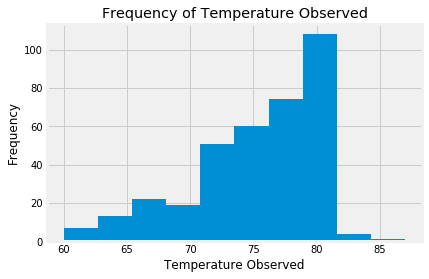

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationTemps_DF.head()
stationTemps_DF.hist(column=["temp_observed"])
plt.ylabel("Frequency")
plt.xlabel("Temperature Observed")
plt.title("Frequency of Temperature Observed")

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
